# Score matching flow

In [15]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
import json_tricks as json
import copy
from functools import partial

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import models
import flows

from jax.experimental import optimizers

key = random.PRNGKey(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Main

In [6]:
%autoreload

In [16]:
d = 3
coords = np.vstack([np.eye(d), np.ones(d).reshape(1, d)]) * 10

# sample m points from the corners of n-simplex

m = 4
idx = random.choice(key, d+1, (m,), replace=False)
means = coords[idx]

target = distributions.GaussianMixture(means, 1, np.ones(m))
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
setup = distributions.Setup(target, proposal)

In [72]:
n_steps = 5000
noise = 0.
particle_lr = 1e-2
learner_lr = 1e-3
n_particles = 1000
key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=noise, sizes=[32, 32, d], patience=0, learner_lr=learner_lr)
# svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, setup, n_particles=100, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True,  bandwidth=None)
sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)

100%|██████████| 5000/5000 [00:17<00:00, 292.88it/s]


In [73]:
# get final particles
target_cov = target.cov
final_particles_list = []
for p in [neural_particles, svgd_particles, sgld_particles]:
    particles, *_ = p.get_params(split_by_group=True)
    final_particles_list.append(particles)
covs = [target.cov] + [np.cov(p, rowvar=False) for p in final_particles_list]
titles = ["True", "neural", "svgd", "sgld"]
neural_final, svgd_final, sgld_final = final_particles_list

## Rundata high dim mixture

#### final samples

In [74]:
true_samples = target.sample(1000)

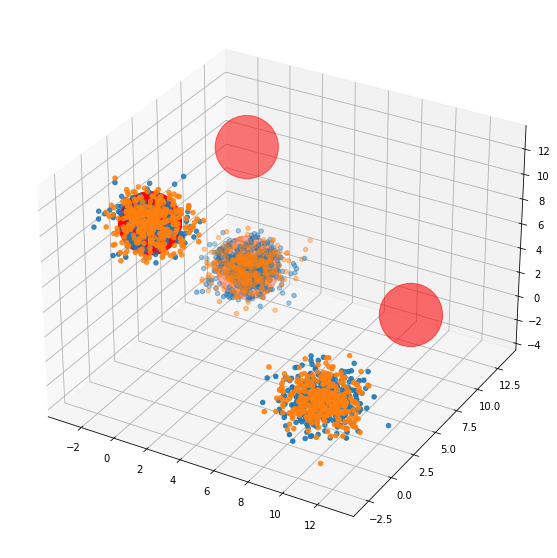

In [75]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*np.rollaxis(neural_final, 1))
ax.scatter(*np.rollaxis(sgld_final, 1))
ax.scatter(*target.means.reshape(3, 4), s=4000, color="red")

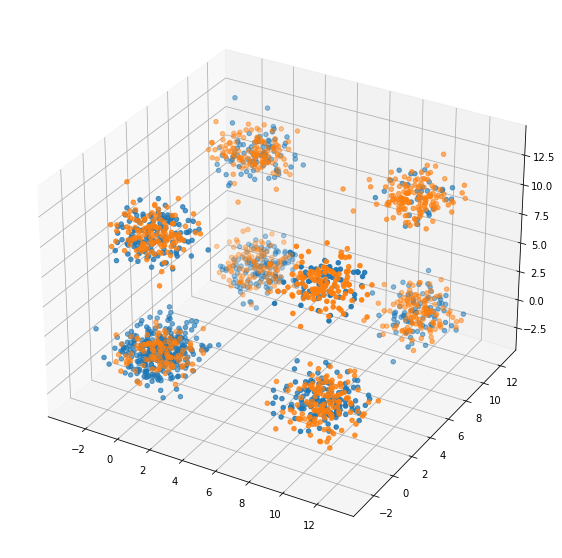

In [76]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*sgld_final.reshape(3, 1000))
ax.scatter(*true_samples.reshape(3, 1000))

#### trajectory

In [77]:
neural_trajectory = np.array(neural_particles.rundata["particles"])
sgld_trajectory = np.array(sgld_particles.rundata["particles"])

neural_trajectory_sliced = neural_trajectory[:, :200, slice_idx]

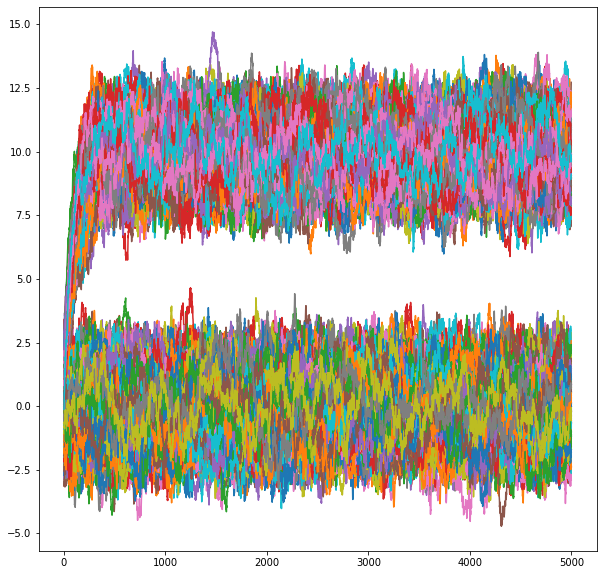

In [79]:
%matplotlib inline
fig, ax = plt.subplots(figsize=[10, 10])
_ = plt.plot(sgld_trajectory[:, :, 0])

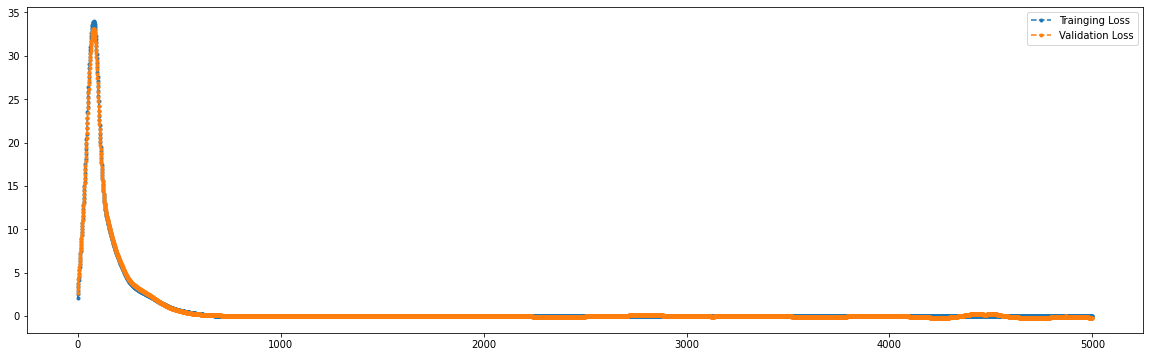

In [80]:
%matplotlib inline
plt.subplots(figsize=[20, 6])
plt.plot(neural_learner.rundata["training_sd"], "--.", label="Trainging Loss")
plt.plot(neural_learner.rundata["validation_sd"], "--.", label="Validation Loss")
# plt.plot(neural_learner.rundata["test_loss"], "--.", label="Test Loss")
# plt.ylim(-100, 100)
plt.legend()

# OLD

In [10]:
# fig, axs = plt.subplots(1, 4, figsize=[18, 5])
# axs = axs.flatten()
# for ax, cov, title in zip(axs, covs, titles):
#     ax.imshow(undo_rot(cov))
#     ax.set_title(title)

NameError: name 'undo_rot' is not defined

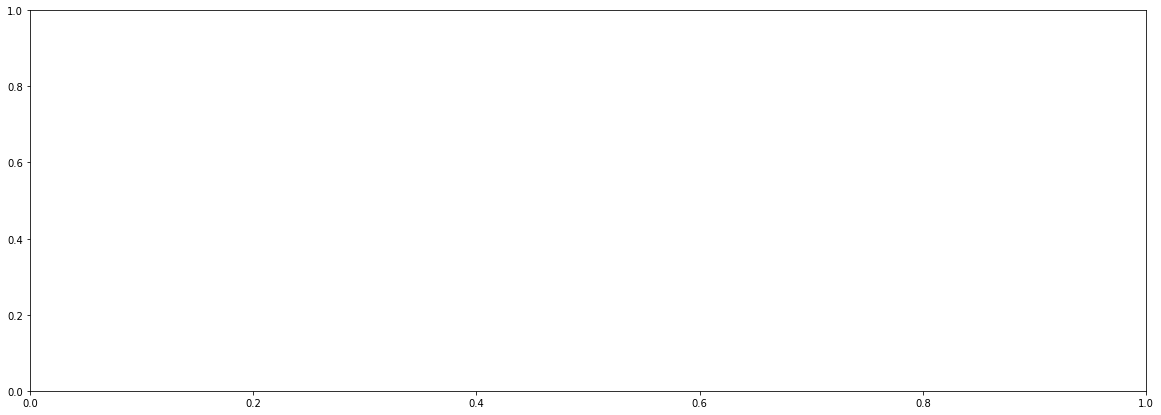

In [11]:
%matplotlib inline
plt.subplots(figsize=[20, 7])
num=3
grid = np.arange(0, d*num, step=num)

for cov_diagonal, name, i in zip([np.diag(undo_rot(cov)) for cov in covs[1:]], ["Neural", "SVGD", "SGLD"], range(3)):
    plt.bar(grid+i, cov_diagonal, alpha=0.5, label=name)

plt.scatter(grid, np.diag(undo_rot(target.cov)), marker="_", label="True")
plt.legend()
plt.yscale("log")

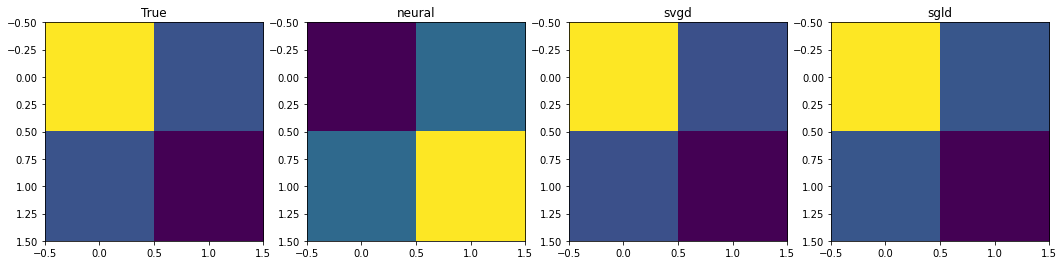

In [27]:
fig, axs = plt.subplots(1, 4, figsize=[18, 5])
axs = axs.flatten()
for ax, cov, title in zip(axs, covs, titles):
    ax.imshow(cov)
    ax.set_title(title)

In [114]:
# %matplotlib inline
# fig, ax = plt.subplots(figsize=[15, 25])
# # plt.ylim((0, 5))
# stdneur = np.array(neural_particles.rundata["training_std"])
# # stdsvgd = svgd_particles.rundata["training_std"]
# # stdsgld = sgld_particles.rundata["training_std"]


# # plt.plot(onp.mean(neural_particles.rundata["validation_std"], axis=1), color="blue", label="Neural Score Matching: Validation particles")
# plt.plot(stdneur, color="tab:blue", label="Neural Score Matching")
# # plt.plot(stdsvgd, color="tab:orange", label="SVGD")
# # plt.plot(stdsgld, color="tab:green", label="SGLD")

# [plt.axhline(y=y, color="black", linestyle="--") for y in np.sqrt(variances)]

# plt.ylabel("Standard Deviation")
# plt.xlabel("Step")

# plt.legend()
# # plt.yscale("log")

## plot learned gradient (projection)

In [12]:
slice_idx = [0, 9]

In [13]:
particles, _ = neural_particles.get_params(split_by_group=True)
# _, particles = neural_particles.get_params(split_by_group=True)
# x0 = particles[0]
x0 = np.zeros(d)

def sliced_grads(xs):
    """function (n, 2) to (n, 2)"""
    n = len(xs)
    x0s = np.tile(x0, (n, 1)) # shape (n, d)
    xs_nd = index_update(x0s, index[:, slice_idx], xs)
    vec_nd = neural_learner.grads(xs_nd)
    return vec_nd[:, slice_idx]

sliced_target = distributions.Gaussian([0, 0], variances[slice_idx])
approx_q = distributions.Gaussian(np.mean(particles, axis=0)[slice_idx], np.var(particles, axis=0)[slice_idx])
sliced_grads_true = vmap(grad(lambda x: sliced_target.logpdf(x) - approx_q.logpdf(x)))

sliced_particles = particles[:, slice_idx] 

NameError: name 'variances' is not defined

NameError: name 'sliced_grads_true' is not defined

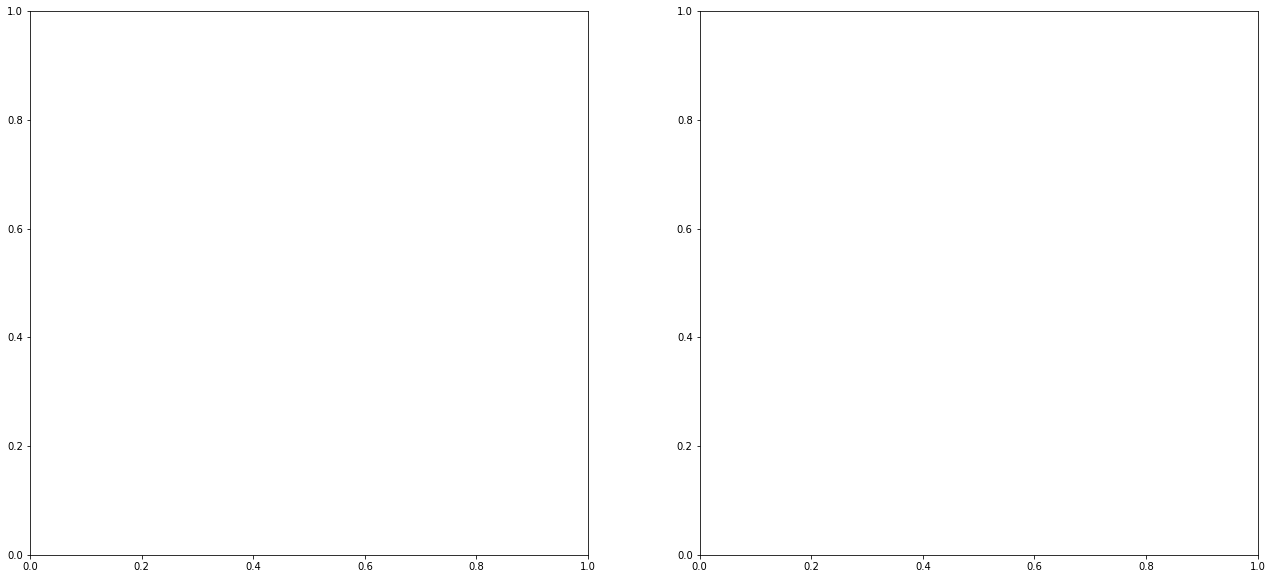

In [14]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize=[22, 10])
axs = axs.flatten()
# lims=(-1/4, 1/4)
lims=(-11, 11)
# lims = utils.get_particle_lims(particles[:, slice_idx])
true_samples = target.sample(1000)
for ax, grad_fn in zip(axs, [sliced_grads, sliced_grads_true]):
    ax.set(xlim=lims, ylim=lims)
#     plot.plot_fun_2d(sliced_target.pdf, lims=lims, ax=ax, alpha=0.5)
    plot.plot_gradient_field(grad_fn, ax, lims=lims)
    plot.scatter(sliced_particles, ax=ax)
    plot.scatter(true_samples[:, slice_idx], ax=ax)

# animation

In [123]:
%matplotlib inline
# fig, ax = plt.subplots(figsize=[10, 10])
# _ = plt.plot(neural_trajectory[:, :, 9])

In [58]:
neural_trajectory_sliced.shape

(100, 200, 2)

In [59]:
np.var(neural_trajectory[800], axis=0)[slice_idx]

DeviceArray([6463.377 , 1819.4465], dtype=float32)

In [154]:
%matplotlib widget
fig, ax = plt.subplots(figsize=[10, 10])
lim=(-11, 11)
# lim=utils.get_particle_lims(sliced_particles)
ax.set(xlim=lim, ylim=lim)
# plot.plot_fun_2d(sliced_target.pdf, lims=lim, ax=ax, alpha=0.5)
plot.animate_array(neural_trajectory_sliced, fig, ax, interval=100)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Loss

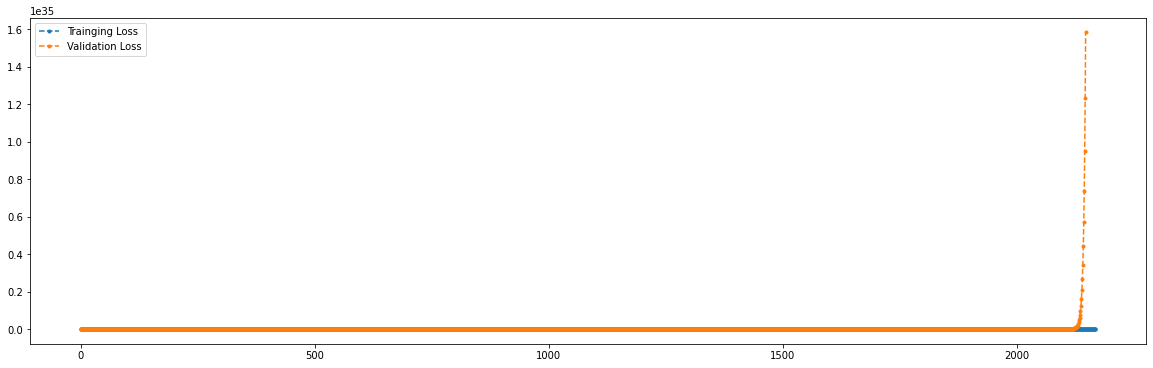

In [69]:
%matplotlib inline
plt.subplots(figsize=[20, 6])
plt.plot(neural_learner.rundata["training_loss"], "--.", label="Trainging Loss")
plt.plot(neural_learner.rundata["validation_loss"], "--.", label="Validation Loss")
# plt.plot(neural_learner.rundata["test_loss"], "--.", label="Test Loss")
# plt.ylim(-100, 100)
plt.legend()

## metrics

In [110]:
psvgd, *_ = svgd_particles.get_params(split_by_group=True)
metrics.compute_final_metrics(psvgd, target)

{'emd': DeviceArray(2.7817569, dtype=float32),
 'ksd': DeviceArray(5.404147, dtype=float32),
 'se_mean': DeviceArray(0.00044847, dtype=float32),
 'se_std': DeviceArray(0.04542517, dtype=float32)}

In [112]:
p, *_ = neural_particles.get_params(split_by_group=True)
metrics.compute_final_metrics(p[:100], target)

{'emd': DeviceArray(3.7362332, dtype=float32),
 'ksd': DeviceArray(0.0062103, dtype=float32),
 'se_mean': DeviceArray(0.00179533, dtype=float32),
 'se_std': DeviceArray(0.00616832, dtype=float32)}

In [113]:
p, *_ = sgld_particles.get_params(split_by_group=True)
metrics.compute_final_metrics(p[:100], target)

{'emd': DeviceArray(3.436739, dtype=float32),
 'ksd': DeviceArray(0.00637997, dtype=float32),
 'se_mean': DeviceArray(0.00175899, dtype=float32),
 'se_std': DeviceArray(0.00098737, dtype=float32)}

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x7ff548b9a910>>
Traceback (most recent call last):
  File "/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/tornado/ioloop.py", line 907, in _run
    return self.callback()
  File "/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/matplotlib/backend_bases.py", line 1194, in _on_timer
    ret = func(*args, **kwargs)
  File "/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/matplotlib/animation.py", line 1424, in _step
    self.event_source.interval = self._repeat_delay
  File "/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/matplotlib/backend_bases.py", line 1135, in interval
    self._timer_set_interval()
  File "/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/matplotlib/backends/backend_webagg_core.py", line 537, in _timer_set_interval
    self._timer_start()
  Fi